# Adaptive Treatment Selection with Multi-Armed  Bandits




## Scenario

A pharmaceutical company is conducting clinical trials to evaluate four antiretroviral drug combinations for HIV-positive patients. The goal is to identify the most effective treatment with minimal patient trials, respecting ethical and cost constraints. Effectiveness is measured by improvements in immune system markers (CD4 counts) and survival status.

## Problem Definition

Simulate a clinical trial using Multi-Armed Bandit (MAB) strategies to sequentially recommend treatments and observe outcomes, maximizing success rates. The environment is implemented using Gymnasium for a standardized RL interface.

## Dataset

- **Fields**:
  - *Age (age)*: Patient age in years.
  - *Weight (wtkg)*: Weight in kilograms.
  - *Gender (gender)*: 0 = Female, 1 = Male.
  - *CD4 Counts (cd40, cd420)*: CD4 counts at baseline and 20±5 weeks.
  - *Treatment Indicator (trt)*: 0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only.
  - *Censoring Indicator (label)*: 1 = failure, 0 = censoring (survival).
- **Link**: [Clinical_Trial.csv](https://drive.google.com/file/d/1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-/view?usp=sharing)

## Environment Setup

- **Arms (Actions)**:
  - Arm 0: ZDV only
  - Arm 1: ZDV + ddI
  - Arm 2: ZDV + Zal
  - Arm 3: ddI only
- **Reward Function**:
  ```
  r = 1, if (label == 0) and (cd420 > cd40)
  r = 0, otherwise
  ```
- **Gymnasium Integration**: Environment uses `gymnasium.Env` with `Discrete(4)` action space and trivial observation space.
- **Assumptions**:
  - Minimum 1000 trials, extendable based on convergence.
  - Each trial simulates one patient.

## Requirements and Deliverables

- **Dataset Loading and Analysis** (0.5 Marks): Load and summarize dataset.
- **Clinical Trial Environment** (0.5 Marks): Implement Gymnasium environment.
- **Random Policy** (0.5 Marks): Implement random policy.
- **Other Policies** (1.5 Marks): Implement Greedy, ε-Greedy (ε=0.1, 0.2, 0.5), UCB.
- **Analysis and Comparison** (1 Mark): Analyze convergence, regret, and visualize results.


## Initialize Constants (0 Marks)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict
import math
import gymnasium as gym
from gymnasium import spaces

# Set random seed
np.random.seed(42)
random.seed(42)

# Constants
NUM_ARMS = 4
MIN_ITERATIONS = 1000
N_RUNS = 50
EPSILONS = [0.1, 0.2, 0.5]
UCB_C = 2.0
TREATMENT_NAMES = {
    0: "ZDV only",
    1: "ZDV + ddI",
    2: "ZDV + Zal",
    3: "ddI only"
}

# Validate constants
assert NUM_ARMS == len(TREATMENT_NAMES), "Number of arms must match treatment names"
assert MIN_ITERATIONS > 0, "Iterations must be positive"
assert all(0 <= e <= 1 for e in EPSILONS), "Epsilon values must be in [0, 1]"
assert UCB_C > 0, "UCB exploration parameter must be positive"
assert N_RUNS > 0, "Number of runs must be positive"

print("=== Multi-Armed Bandit Clinical Trial Simulation ===")
print(f"Number of treatment arms: {NUM_ARMS}")
print(f"Minimum iterations: {MIN_ITERATIONS}")
print(f"Number of runs: {N_RUNS}")
print("Treatment options:", TREATMENT_NAMES)


=== Multi-Armed Bandit Clinical Trial Simulation ===
Number of treatment arms: 4
Minimum iterations: 1000
Number of runs: 50
Treatment options: {0: 'ZDV only', 1: 'ZDV + ddI', 2: 'ZDV + Zal', 3: 'ddI only'}


## Load Dataset (0.5 Marks)

In [4]:
def load_and_analyze_dataset():
    """Load and analyze clinical trial dataset."""
    try:
        df = pd.read_csv('Clinical_Trial.csv')
    except FileNotFoundError:
        print("Error: Clinical_Trial.csv not found.")
        raise

    print("\n=== Dataset Loading and Statistics ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Total patients: {len(df)}")

    print("\nDataset Info:")
    print(df.info())

    print("\nFirst 5 rows:")
    print(df.head())

    print("\nStatistical Summary:")
    print(df.describe())

    print("\nTreatment Distribution:")
    treatment_counts = df['trt'].value_counts().sort_index()
    for trt, count in treatment_counts.items():
        print(f"  {TREATMENT_NAMES[trt]}: {count} patients ({count/len(df)*100:.1f}%)")

    print("\nOutcome Distribution:")
    print(f"  Censored (survived): {sum(df['label'] == 0)} patients ({sum(df['label'] == 0)/len(df)*100:.1f}%)")
    print(f"  Failed: {sum(df['label'] == 1)} patients ({sum(df['label'] == 1)/len(df)*100:.1f}%)")

    print("\nCD4 Count Analysis:")
    print(f"  Average baseline CD4: {df['cd40'].mean():.1f}")
    print(f"  Average follow-up CD4: {df['cd420'].mean():.1f}")
    cd4_improved = sum(df['cd420'] > df['cd40'])
    print(f"  Patients with CD4 improvement: {cd4_improved} ({cd4_improved/len(df)*100:.1f}%)")

    return df

# Load dataset
dataset = load_and_analyze_dataset()



=== Dataset Loading and Statistics ===
Dataset shape: (2139, 7)
Total patients: 2139

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     2139 non-null   int64  
 1   wtkg    2139 non-null   float64
 2   gender  2139 non-null   int64  
 3   cd40    2139 non-null   int64  
 4   cd420   2139 non-null   int64  
 5   trt     2139 non-null   int64  
 6   label   2139 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 117.1 KB
None

First 5 rows:
   age     wtkg  gender  cd40  cd420  trt  label
0   48  89.8128       0   422    477    2      0
1   61  49.4424       0   162    218    3      1
2   45  88.4520       1   326    274    3      0
3   47  85.2768       1   287    394    3      0
4   43  66.6792       1   504    353    0      0

Statistical Summary:
               age         wtkg       gender         cd40        cd420  

## Design a Clinical Trial Environment with Gymnasium (0.5 Marks)

In [5]:
import pandas as pd
import numpy as np
from typing import Dict
import gymnasium as gym
from gymnasium import spaces

class ClinicalTrialEnv(gym.Env):
    """Gymnasium environment for clinical trial MAB simulation."""
    metadata = {"render_modes": ["human"]}

    def __init__(self, dataset: pd.DataFrame):
        """Initialize with clinical trial data.

        Args:
            dataset: DataFrame with patient records
        """
        super().__init__()
        self.dataset = dataset
        self.num_arms = NUM_ARMS
        self.treatment_data = {}

        self.action_space = spaces.Discrete(NUM_ARMS)
        self.observation_space = spaces.Box(low=0, high=0, shape=(1,), dtype=np.float32)

        for arm in range(self.num_arms):
            arm_data = dataset[dataset["trt"] == arm].copy()
            if len(arm_data) == 0:
                raise ValueError(f"No data for arm {arm} ({TREATMENT_NAMES[arm]})")
            self.treatment_data[arm] = arm_data
            print(f"Arm {arm} ({TREATMENT_NAMES[arm]}): {len(arm_data)} patients")

    def reset(self, seed=None, options=None):
        """Reset environment (stateless for MAB).

        Returns:
            tuple: (observation, info)
        """
        super().reset(seed=seed)
        observation = np.array([0.0], dtype=np.float32)
        info = {}
        return observation, info

    def step(self, action: int):
        """Take action (select arm) and return outcome.

        Args:
            action: Treatment arm (0-3)

        Returns:
            tuple: (observation, reward, terminated, truncated, info)
        """
        if action not in self.treatment_data or len(self.treatment_data[action]) == 0:
            reward = 0
            info = {}
        else:
            patient = self.treatment_data[action].sample(n=1).iloc[0]
            survived = patient["label"] == 0
            cd4_improved = patient["cd420"] > patient["cd40"]
            reward = 1 if (survived and cd4_improved) else 0
            info = {
                "age": patient["age"],
                "gender": patient["gender"],
                "cd40": patient["cd40"],
                "cd420": patient["cd420"],
                "label": patient["label"],
                "survived": survived,
                "cd4_improved": cd4_improved
            }

        observation = np.array([0.0], dtype=np.float32)
        terminated = False
        truncated = False

        return observation, reward, terminated, truncated, info

    def render(self):
        """Render environment (placeholder)."""
        pass

    def calculate_true_reward_rates(self) -> Dict[int, float]:
        """Calculate true reward rate for each arm.

        Returns:
            dict: Mapping of arm index to true reward rate
        """
        rates = {}
        for arm in range(self.num_arms):
            arm_data = self.treatment_data[arm]
            if len(arm_data) == 0:
                rates[arm] = 0.0
            else:
                successful = ((arm_data["label"] == 0) & (arm_data["cd420"] > arm_data["cd40"])).sum()
                rates[arm] = successful / len(arm_data)

        print("\n=== True Reward Rates ===")
        for arm, rate in rates.items():
            print(f"Arm {arm} ({TREATMENT_NAMES[arm]}): {rate:.3f} ({rate*100:.1f}%)")

        return rates

# Initialize environment
env = ClinicalTrialEnv(dataset)
true_rates = env.calculate_true_reward_rates()


Arm 0 (ZDV only): 532 patients
Arm 1 (ZDV + ddI): 522 patients
Arm 2 (ZDV + Zal): 524 patients
Arm 3 (ddI only): 561 patients

=== True Reward Rates ===
Arm 0 (ZDV only): 0.329 (32.9%)
Arm 1 (ZDV + ddI): 0.565 (56.5%)
Arm 2 (ZDV + Zal): 0.458 (45.8%)
Arm 3 (ddI only): 0.481 (48.1%)


## Using Random Policy (0.5 Marks)

In [6]:
def run_random_policy(env: gym.Env, iterations: int = MIN_ITERATIONS) -> Dict:
    """Run random policy for MAB clinical trial.

    Args:
        env: Gymnasium environment
        iterations: Number of trials

    Returns:
        dict: Results including arm counts, rewards, and history
    """
    print(f"\n=== Running Random Policy for {iterations} iterations ===")

    arm_counts = np.zeros(NUM_ARMS)
    arm_rewards = np.zeros(NUM_ARMS)
    rewards_history = []
    arms_history = []

    observation, _ = env.reset()
    for iteration in range(iterations):
        action = env.action_space.sample()
        observation, reward, _, _, _ = env.step(action)

        arm_counts[action] += 1
        arm_rewards[action] += reward
        rewards_history.append(reward)
        arms_history.append(action)

    results = {
        "arm_counts": arm_counts,
        "arm_rewards": arm_rewards,
        "rewards_history": np.array(rewards_history),
        "arms_history": np.array(arms_history),
        "name": "Random"
    }

    print("\nRandom Policy Results:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Treatment", "Pulls", "Rewards", "Est. Rate"))
    print("-" * 45)
    for arm in range(NUM_ARMS):
        rate = arm_rewards[arm] / arm_counts[arm] if arm_counts[arm] > 0 else 0
        print(f"{TREATMENT_NAMES[arm]:<15} {int(arm_counts[arm]):<10} {arm_rewards[arm]:<10.0f} {rate:.3f}")

    return results

# Run random policy
random_results = run_random_policy(env)



=== Running Random Policy for 1000 iterations ===

Random Policy Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        270        92         0.341
ZDV + ddI       257        142        0.553
ZDV + Zal       234        101        0.432
ddI only        239        114        0.477


## Using Other Policies (1.5 Marks)

In [7]:
def run_greedy_policy(env: gym.Env, iterations: int = MIN_ITERATIONS) -> Dict:
    """Run greedy policy for MAB clinical trial.

    Args:
        env: Gymnasium environment
        iterations: Number of trials

    Returns:
        dict: Results including arm counts, rewards, and history
    """
    print(f"\n=== Running Greedy Policy for {iterations} iterations ===")

    arm_counts = np.zeros(NUM_ARMS)
    arm_rewards = np.zeros(NUM_ARMS)
    rewards_history = []
    arms_history = []

    observation, _ = env.reset()
    for arm in range(NUM_ARMS):
        observation, reward, _, _, _ = env.step(arm)
        arm_counts[arm] += 1
        arm_rewards[arm] += reward
        rewards_history.append(reward)
        arms_history.append(arm)

    for iteration in range(NUM_ARMS, iterations):
        means = arm_rewards / np.maximum(arm_counts, 1)
        action = np.argmax(means)
        observation, reward, _, _, _ = env.step(action)

        arm_counts[action] += 1
        arm_rewards[action] += reward
        rewards_history.append(reward)
        arms_history.append(action)

    results = {
        "arm_counts": arm_counts,
        "arm_rewards": arm_rewards,
        "rewards_history": np.array(rewards_history),
        "arms_history": np.array(arms_history),
        "name": "Greedy"
    }

    print("\nGreedy Policy Results:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Treatment", "Pulls", "Rewards", "Est. Rate"))
    print("-" * 45)
    for arm in range(NUM_ARMS):
        rate = arm_rewards[arm] / arm_counts[arm] if arm_counts[arm] > 0 else 0
        print(f"{TREATMENT_NAMES[arm]:<15} {int(arm_counts[arm]):<10} {arm_rewards[arm]:<10.0f} {rate:.3f}")

    return results

def run_epsilon_greedy_policy(env: gym.Env, epsilon: float, iterations: int = MIN_ITERATIONS) -> Dict:
    """Run ε-greedy policy for MAB clinical trial.

    Args:
        env: Gymnasium environment
        epsilon: Exploration rate
        iterations: Number of trials

    Returns:
        dict: Results including arm counts, rewards, and history
    """
    print(f"\n=== Running ε-Greedy Policy (ε={epsilon}) for {iterations} iterations ===")

    arm_counts = np.zeros(NUM_ARMS)
    arm_rewards = np.zeros(NUM_ARMS)
    rewards_history = []
    arms_history = []

    observation, _ = env.reset()
    for iteration in range(iterations):
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            means = arm_rewards / np.maximum(arm_counts, 1)
            action = np.argmax(means)

        observation, reward, _, _, _ = env.step(action)
        arm_counts[action] += 1
        arm_rewards[action] += reward
        rewards_history.append(reward)
        arms_history.append(action)

    results = {
        "arm_counts": arm_counts,
        "arm_rewards": arm_rewards,
        "rewards_history": np.array(rewards_history),
        "arms_history": np.array(arms_history),
        "name": f"ε-Greedy (ε={epsilon})"
    }

    print(f"\nε-Greedy (ε={epsilon}) Results:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Treatment", "Pulls", "Rewards", "Est. Rate"))
    print("-" * 45)
    for arm in range(NUM_ARMS):
        rate = arm_rewards[arm] / arm_counts[arm] if arm_counts[arm] > 0 else 0
        print(f"{TREATMENT_NAMES[arm]:<15} {int(arm_counts[arm]):<10} {arm_rewards[arm]:<10.0f} {rate:.3f}")

    return results

def run_ucb_policy(env: gym.Env, c: float, iterations: int = MIN_ITERATIONS) -> Dict:
    """Run UCB policy for MAB clinical trial.

    Args:
        env: Gymnasium environment
        c: Exploration parameter
        iterations: Number of trials

    Returns:
        dict: Results including arm counts, rewards, and history
    """
    print(f"\n=== Running UCB Policy for c={c} for {iterations} iterations ===")

    arm_counts = np.zeros(NUM_ARMS)
    arm_rewards = np.zeros(NUM_ARMS)
    rewards_history = []
    arms_history = []

    observation, _ = env.reset()
    for arm in range(NUM_ARMS):
        observation, reward, _, _, _ = env.step(arm)
        arm_counts[arm] = 1
        arm_rewards[arm] = reward
        rewards_history.append(reward)
        arms_history.append(arm)

    for t in range(NUM_ARMS, iterations):
        means = arm_rewards / arm_counts
        ucb_values = means + c * np.sqrt(np.log(t + 1) / arm_counts)
        action = np.argmax(ucb_values)
        observation, reward, _, _, _ = env.step(action)

        arm_counts[action] += 1
        arm_rewards[action] += reward
        rewards_history.append(reward)
        arms_history.append(action)

    results = {
        "arm_counts": arm_counts,
        "arm_rewards": arm_rewards,
        "rewards_history": np.array(rewards_history),
        "arms_history": np.array(arms_history),
        "name": "UCB"
    }

    print("\nUCB Results:")
    print("{:<15} {:<10} {:<10} {:<10}".format("Treatment", "Pulls", "Rewards", "Est. Rate"))
    print("-" * 45)
    for arm in range(NUM_ARMS):
        rate = arm_rewards[arm] / arm_counts[arm] if arm_counts[arm] > 0 else 0
        print(f"{TREATMENT_NAMES[arm]:<15} {int(arm_counts[arm]):<10} {arm_rewards[arm]:<10.0f} {rate:.3f}")

    return results

# Run all policies
all_results = [random_results]
all_results.append(run_greedy_policy(env))
for epsilon in EPSILONS:
    all_results.append(run_epsilon_greedy_policy(env, epsilon))
all_results.append(run_ucb_policy(env, UCB_C))



=== Running Greedy Policy for 1000 iterations ===

Greedy Policy Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        1          0          0.000
ZDV + ddI       7          2          0.286
ZDV + Zal       1          0          0.000
ddI only        991        492        0.496

=== Running ε-Greedy Policy (ε=0.1) for 1000 iterations ===

ε-Greedy (ε=0.1) Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        56         19         0.339
ZDV + ddI       22         9          0.409
ZDV + Zal       31         14         0.452
ddI only        891        428        0.480

=== Running ε-Greedy Policy (ε=0.2) for 1000 iterations ===

ε-Greedy (ε=0.2) Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        59         19         0.322
ZDV + ddI       797        451        0.566
ZDV + Zal       56      

## Analysis and Comparison (1 Mark)


=== Convergence Analysis ===
Best arm (true rate): ZDV + ddI (Arm 1, Rate 0.565)
Random: Did not converge to best arm
Greedy: Did not converge to best arm
ε-Greedy (ε=0.1): Did not converge to best arm
ε-Greedy (ε=0.2): Did not converge to best arm
ε-Greedy (ε=0.5): Did not converge to best arm
UCB: Did not converge to best arm

=== Evaluating Policies over 50 Runs ===

=== Running Random Policy for 1000 iterations ===

Random Policy Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        247        67         0.271
ZDV + ddI       235        133        0.566
ZDV + Zal       233        111        0.476
ddI only        285        154        0.540

=== Running Random Policy for 1000 iterations ===

Random Policy Results:
Treatment       Pulls      Rewards    Est. Rate 
---------------------------------------------
ZDV only        255        88         0.345
ZDV + ddI       248        139        0.560
ZDV + Zal       255    

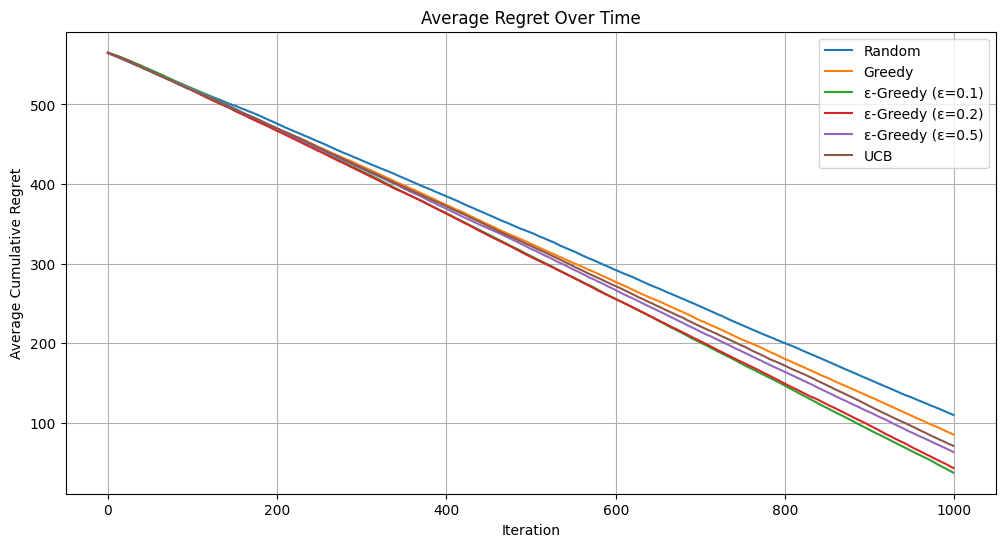

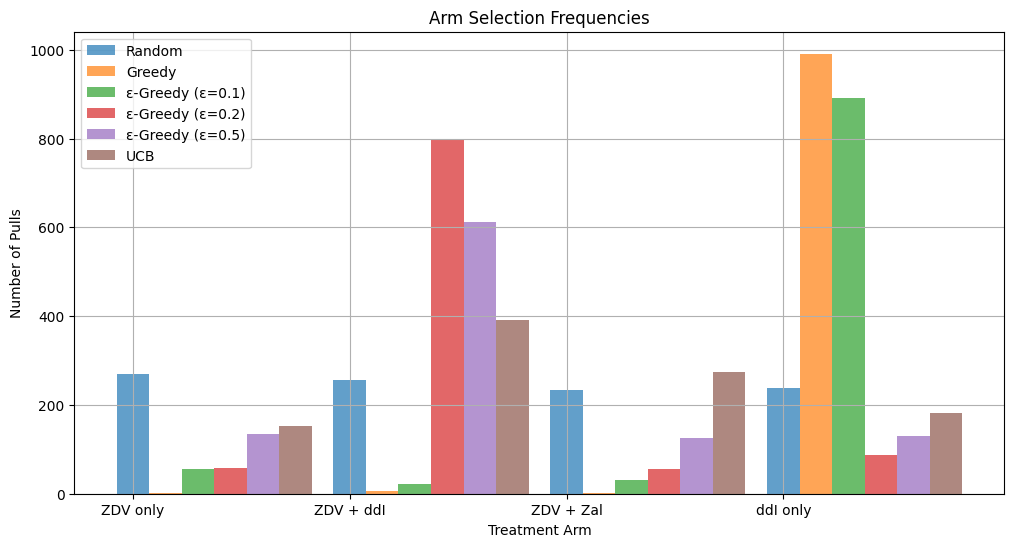

In [8]:
def analyze_convergence(all_results):
    """Analyze convergence of policies to the best arm.

    Args:
        all_results: List of policy result dictionaries
    """
    best_arm = max(true_rates, key=true_rates.get)
    print(f"\n=== Convergence Analysis ===")
    print(f"Best arm (true rate): {TREATMENT_NAMES[best_arm]} (Arm {best_arm}, Rate {true_rates[best_arm]:.3f})")

    for result in all_results:
        arms_history = result["arms_history"]
        convergence_point = -1
        for i in range(len(arms_history) - 100):
            if np.all(arms_history[i:i+100] == best_arm):
                convergence_point = i
                break
        if convergence_point == -1:
            print(f"{result['name']}: Did not converge to best arm")
        else:
            print(f"{result['name']}: Converged at iteration {convergence_point}")

def evaluate_policies(env: gym.Env, iterations: int = MIN_ITERATIONS, n_runs: int = N_RUNS):
    """Evaluate policies over multiple runs and plot results.

    Args:
        env: Gymnasium environment
        iterations: Number of trials per run
        n_runs: Number of runs

    Returns:
        tuple: (all_regrets, all_cum_rewards)
    """
    print(f"\n=== Evaluating Policies over {n_runs} Runs ===")

    optimal_reward = max(true_rates.values()) * iterations
    policies = [
        ("Random", lambda e: run_random_policy(e, iterations)),
        ("Greedy", lambda e: run_greedy_policy(e, iterations)),
        *[("ε-Greedy (ε={})".format(e), lambda e, eps=e: run_epsilon_greedy_policy(e, eps, iterations)) for e in EPSILONS],
        ("UCB", lambda e: run_ucb_policy(e, UCB_C, iterations))
    ]

    all_regrets = {}
    all_cum_rewards = {}

    for name, policy_func in policies:
        regrets = np.zeros((n_runs, iterations))
        cum_rewards = np.zeros((n_runs, iterations))
        for run in range(n_runs):
            results = policy_func(env)
            rewards = results["rewards_history"]
            cum_rewards[run] = np.cumsum(rewards)
            regrets[run] = optimal_reward - cum_rewards[run]
        all_regrets[name] = regrets
        all_cum_rewards[name] = cum_rewards

        mean_reward = np.mean(cum_rewards[:, -1])
        ci = 1.96 * np.std(cum_rewards[:, -1]) / np.sqrt(n_runs)
        print(f"{name} Avg Cumulative Reward: {mean_reward:.2f} ± {ci:.2f}")

    plt.figure(figsize=(12, 6))
    for name, regrets in all_regrets.items():
        plt.plot(np.mean(regrets, axis=0), label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Average Cumulative Regret")
    plt.title("Average Regret Over Time")
    plt.legend()
    plt.grid(True)
    plt.savefig("regret_plot.png", format="png", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(12, 6))
    width = 0.15
    x = np.arange(NUM_ARMS)
    for i, result in enumerate(all_results):
        plt.bar(x + i * width, result["arm_counts"], width, label=result["name"], alpha=0.7)
    plt.xlabel("Treatment Arm")
    plt.ylabel("Number of Pulls")
    plt.title("Arm Selection Frequencies")
    plt.xticks(x, [TREATMENT_NAMES[i] for i in range(NUM_ARMS)])
    plt.legend()
    plt.grid(True)
    plt.savefig("arm_frequencies.png", format="png", bbox_inches="tight")
    plt.show()

    return all_regrets, all_cum_rewards

# Run analysis
analyze_convergence(all_results)
all_regrets, all_cum_rewards = evaluate_policies(env)
